Acquiring and Processing Information on the World's Largest Banks
===========================
_Instructions and dataset taken from IBM's **[Python Project for Data Engineering](https://www.coursera.org/learn/python-project-for-data-engineering)** in Coursera_


# Scenario
- apply data-cleaning skills to process information about marketing campaigns run by a bank
-modify values, add new features, convert data types as required by the client
- save data into multiple files

You have been hired as a data engineer by research organization. Your boss has asked you to create a code that can be used to compile the list of the top 10 largest banks in the world ranked by market capitalization in billion USD from [Wikipedia: List of Largest Banks](https://web.archive.org/web/20230908091635%20/https://en.wikipedia.org/wiki/List_of_largest_banks).

Further, the data needs to be transformed and stored in GBP, EUR and INR as well, in accordance with the exchange rate information that has been made available to you as a CSV file.

The information required are:

| Column Name | Description |
| ----------- | ----------- |
| `Name` | Name of the bank as listed in target website|
| `MC_USD_Billion` | Market capitalization amount in billions of **US Dollar**, as listed in target website |
| `MC_GBP_Billion` | Market capitalization amount in billions of **Great Britain Pound**, converted from `MC_USD_Billion` using the given [exchange_rate.csv](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv) |
| `MC_EUR_Billion` | Market capitalization amount in billions of **Euro**, converted from `MC_USD_Billion` using the given [exchange_rate.csv](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv) |
| `MC_INR_Billion` | Market capitalization amount in billions of **Indian Rupee**, converted from `MC_USD_Billion` using the given [exchange_rate.csv](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv) |

The processed information table is to be saved locally in a CSV format and as a database table.

Your job is to create an automated system to generate this information so that the same can be executed in every financial quarter to prepare the report.

# Prerequisite Steps
## 1. Gather the other required data file/s
```
cd data
wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv
```

> [!NOTE]
> In case of unavailability, a snapshot of `exchange_rate.csv` is also available in the root directory.
> Date of snapshot: `2025 Apr 11`

## 2. Install required libraries
```
python -m pip install -r requirements.txt
```

# Project Tasks

In [285]:
# for data frame compilation and utilities
import pandas as pd

# for numerical computations and types
import numpy as np

# for deleting the output files, if existing, before the whole ETL process is run
import os, glob

# for log timestamps
from datetime import datetime

# for getting html document from target url
import requests

# for parsing html document
from bs4 import BeautifulSoup

# for connecting to DB
import sqlite3

# for stopping execution on test failure
import sys

In [286]:
# Delete output files, if existing, to start each run with a clean slate
for f in glob.glob("output/*.csv"):
    os.remove(f)

for f in glob.glob("output/*.db"):
    os.remove(f)

## Task 1: Create the Logging method
Write a function `log_progress()` to log the progress of the code at different stages in a file
`code_log.txt`. Use the list of log points provided to create logentries as every stage of the code.

In [287]:
PATH_TO_LOGFILE = "code_log.txt"

def log_progress(msg, tee_enabled=True):
    """Write event log with timestamp to file specified.

    Keyword Arguments:
    msg -- string message to log
    tee -- optional boolean to enable mirroring of log message to stdout
        Default: True

    Return:
    None
    """
    timestamp_format = "%Y-%h-%d-%H:%M:%S"
    now = datetime.now()
    timestamp_str = now.strftime(timestamp_format)

    log_str = timestamp_str + ": " + msg + "\n"

    if tee_enabled:
        print(log_str, end='')

    with open(PATH_TO_LOGFILE, "a") as f:
        f.write(log_str)

## Task 2: Extraction
Extract the tabular information from the given URL under the heading 'By market capitalization' and save it to a dataframe.

1. Inspect the webpage and identify the position and pattern of the tabular information in the HTML code
2. Write the code for a function `extract()` to perform the required data extraction.
3. Execute a function call to `extract()` to verify the output.

First, let's explore the target table in the target URL using the "Inspect" functionality in a browser:
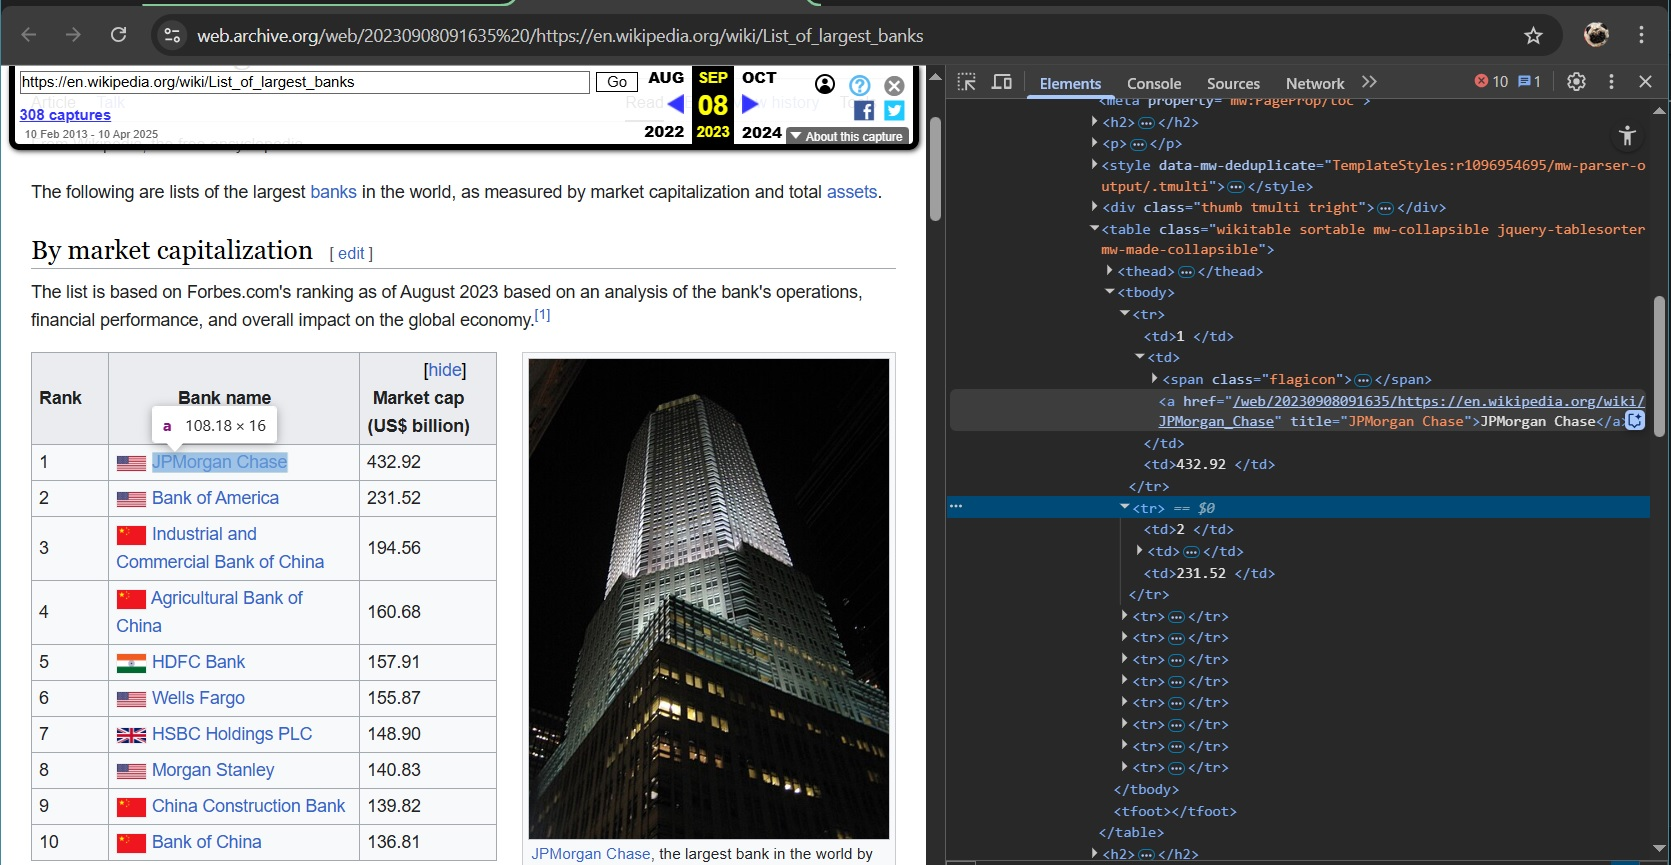

We glean from here that:
- our target table is the first table in the document
- the `Name` data we need is in the 2nd column of each row inside an `<a>` or hyperlink tag
- the `MC_USD_Billion` data we need is in the 3rd column of each row

We can therefore write the `extract()` function as follows:

In [288]:
def extract(url):
    """Performs the transform process for the needed bank data

    Keyword Arguments:
    url -- target url to be scraped

    Return:
    Pandas dataframe containing extracted data
    """
    log_progress("extract(): started")

    log_progress(f"extract(): sending GET request to {url}")
    r = requests.get(url)
    log_progress(f"extract(): got response for GET request, status_code={r.status_code}")
    html_page = r.text
    data = BeautifulSoup(html_page, "html.parser")
    tables = data.find_all('tbody')
    rows = tables[0].find_all('tr')

    # Initialize list to hold dicts (1 dict = 1 row)
    output_rows_list = []

    row_count = 0
    
    for row in rows:
        # Skip empty rows
        row_data = row.find_all('td')
        if len(row_data) < 3:
            continue

        # Skip rows without bank name links
        bank_links = row_data[1].find_all('a')
        if len(bank_links) < 2:
            continue

        bank_name = bank_links[1].string
        marketcap = float(row_data[2].text)

        # Create data dict from extracted data, then append to list of rows
        data_dict = {
                    "Name":bank_name,
                     "MC_USD_Billion":marketcap
                    }

        output_rows_list.append(data_dict)
        row_count = row_count + 1

    output_df = pd.DataFrame.from_dict(output_rows_list)

    log_progress(f"extract(): extracted datarame head:\n{output_df.head()}\n")
    log_progress(f"extract(): finished")
    return output_df

Calling the `extract()` function:

In [289]:
WEBSCRAPING_TARGET_URL="https://web.archive.org/web/20230908091635 /https://en.wikipedia.org/wiki/List_of_largest_banks"

# Extract data
log_progress("ETL prcess started. Extracting data...")
extracted_df = extract(url=WEBSCRAPING_TARGET_URL)

2025-Apr-13-14:51:44: ETL prcess started. Extracting data...
2025-Apr-13-14:51:44: extract(): started
2025-Apr-13-14:51:44: extract(): sending GET request to https://web.archive.org/web/20230908091635 /https://en.wikipedia.org/wiki/List_of_largest_banks
2025-Apr-13-14:51:45: extract(): got response for GET request, status_code=200
2025-Apr-13-14:51:45: extract(): extracted datarame head:
                                      Name  MC_USD_Billion
0                           JPMorgan Chase          432.92
1                          Bank of America          231.52
2  Industrial and Commercial Bank of China          194.56
3               Agricultural Bank of China          160.68
4                                HDFC Bank          157.91

2025-Apr-13-14:51:45: extract(): finished


Before moving on to the next step, let's test the correctness of the extract output:

In [290]:
def test_extract(extracted_df:pd.DataFrame):
    log_progress("test_extract(): started")
    try:
        # assert output has the expected number of rows and columns
        expected_num_rows = 10
        expected_num_cols = 2
        assert(extracted_df.shape == (expected_num_rows, expected_num_cols)), \
            f"Expected shape is ({expected_num_rows},{expected_num_cols}); Actual: {extracted_df.shape}"

        # assert correctness of 'Name' column
        assert('Name' in extracted_df.columns), \
            f"'Name' column not found in extracted dataframe columns: {extracted_df.columns}"
        assert(extracted_df.dtypes['Name'] == 'object'), \
            f"Expected type of 'Name' column: object; Actual: {extracted_df.dtypes['Name']}"

        # assert correctness of 'MC_USD_Billion' column
        assert('MC_USD_Billion' in extracted_df.columns), \
            f"'MC_USD_Billion' column not found in extracted dataframe columns: {extracted_df.columns}"
        assert(extracted_df.dtypes['MC_USD_Billion'] == 'float64'), \
            f"Expected type of 'MC_USD_Billion' column: float64; Actual: {extracted_df.dtypes['MC_USD_Billion']}"

    except AssertionError as e:
        msg = f"ERROR: test_extract() failed: {e}"
        log_progress(msg)
        sys.exit(msg)
    log_progress("test_extract(): finished without errors")

# Run extract tests:
test_extract(extracted_df)

2025-Apr-13-14:51:45: test_extract(): started
2025-Apr-13-14:51:45: test_extract(): finished without errors


## Task 3: Transformation
Transform the dataframe by adding columns for Market Capitalization in GBP, EUR and INR, rounded to 2 decimal places, based on the exchange rateinformation shared as a CSV file.
1. Write the code for a function `transform()` to perform the said task.
2. Execute a function call to `transform()` and verify the output.

First let's create a function for getting the exchange rate information from the CSV file.

In [291]:
PATH_TO_EXCHANGE_RATE_CSV="data/exchange_rate.csv"

def get_exchange_rate_df(path_to_exchange_rate_csv):
    """Return a dataframe containing exchange rate information from `path_to_exchange_rate_csv`
    
    Keyword Arguments:
    path_to_exchange_rate_csv -- file path to exchange rate csv file
        HINT: get from https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv

    Return:
    Pandas dataframe containing exchange rate info, e.g.
                   Rate
        Currency
        EUR        0.93
        GBP        0.80
        INR       82.95
    """
    log_progress("get_exchange_rate_df(): started")
    try:
        exchange_rate_df = pd.read_csv(path_to_exchange_rate_csv, index_col="Currency")
        exchange_rate_df.loc[:, "Rate"] = exchange_rate_df.loc[:,"Rate"].astype(float)
    except FileNotFoundError as e:
        log_progress(f"get_exchange_rate_df(): ERROR: Cannot find exchange rate CSV file: '{path_to_exchange_rate_csv}'.")
    except IndexError as e:
        log_progress(f"get_exchange_rate_df(): ERROR: Wrong or incomplete exchange rate contents in CSV file '{path_to_exchange_rate_csv}'. Required columns: 'Currency', 'Rate'.")

    log_progress("get_exchange_rate_df(): finished, got exchange rates:\n"
                               f"{exchange_rate_df.head()}\n")
    return exchange_rate_df

In [292]:
get_exchange_rate_df(PATH_TO_EXCHANGE_RATE_CSV)

2025-Apr-13-14:51:45: get_exchange_rate_df(): started
2025-Apr-13-14:51:45: get_exchange_rate_df(): finished, got exchange rates:
           Rate
Currency       
EUR        0.93
GBP        0.80
INR       82.95



,Rate
Currency,
EUR,0.93
GBP,0.80
INR,82.95


Next, let's create another utility function for converting USD currency values to other currencies available in the exchange rate dataframe:

In [293]:
def convert_usd(tgt_currency,  src_usd_series:pd.Series,
                exchange_rate_df:pd.DataFrame, round_decimals=2):
    """Returns converted and rounded values from USD to `tgt_currency` using exchange rate from `exchange_rate_df`
    
    Keyword Arguments:
    tgt_currency -- target currency for conversion, e.g. 'EUR', 'GBP', 'INR'
    src_usd_series -- pandas series object containing values to be converted
    exchange_rate_df -- pandas dataframe object containing exchange rate info;
        -- Required columns: 'Currency', 'Rate'
        -- HINT: use `get_exchange_rate_df()`
    round_decimals -- number of decimals to round result to
        -- Default: 2

    Return:
    Pandas series containing converted values
    """
    log_progress(f"convert_usd(): started with tgt_currency:'{tgt_currency}, "
                               f"round_decimals: '{round_decimals}'")
    try:
        converted_series = src_usd_series * exchange_rate_df.loc[tgt_currency]['Rate']
        converted_series = np.round(converted_series, round_decimals)
    except IndexError as e:
        log_progress(f"convert_usd(): ERROR: '{tgt_currency}' not found in exchange rate file provided. Supported currencies are: {exchange_rate_df['Currency']}")

    log_progress("convert_usd(): finished'")
    return converted_series

Finally, we can write our `transform()` method as follows:

In [294]:
OUTPUT_COLUMNS = ["Name", "MC_USD_Billion", "MC_GBP_Billion", "MC_EUR_Billion", "MC_INR_Billion"]

def transform(df, path_to_exchange_rate_csv):
    """Performs the transform process for the needed bank data

    Keyword Arguments:
    df -- pandas dataframe containing raw extracted data
    path_to_exchange_rate_csv -- file path to exchange rate csv
        HINT: get from https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv
    
    Return:
    Pandas dataframe containing transformed data
    """
    log_progress("transform(): started")
    transformed_df = pd.DataFrame(columns=OUTPUT_COLUMNS)

    # Copy Name and MC_USD_Billion columns
    transformed_df["Name"] = df.loc[:, "Name"].copy()
    transformed_df["MC_USD_Billion"] = df.loc[:, "MC_USD_Billion"].copy()

    # Read exchange rate info from `path_to_exchange_rate_csv`
    exchange_rate_df = get_exchange_rate_df(path_to_exchange_rate_csv)

    # Compute the GBP, EUR, and INR column values based from the USD column values
    transformed_df["MC_GBP_Billion"] = convert_usd('GBP',
                                                   src_usd_series=df.loc[:, "MC_USD_Billion"],
                                                   exchange_rate_df=exchange_rate_df)
    transformed_df["MC_EUR_Billion"] = convert_usd('EUR',
                                                   src_usd_series=df.loc[:, "MC_USD_Billion"],
                                                   exchange_rate_df=exchange_rate_df)
    transformed_df["MC_INR_Billion"] = convert_usd('INR',
                                                   src_usd_series=df.loc[:, "MC_USD_Billion"],
                                                   exchange_rate_df=exchange_rate_df)

    log_progress(f"transform(): transformed dataframe head:\n{transformed_df.head()}\n")
    log_progress(f"transform(): finished")
    return transformed_df

Calling `transform()`:

In [295]:
# Transform data
log_progress("Data extraction complete. Transforming data...")
transformed_df = transform(extracted_df, PATH_TO_EXCHANGE_RATE_CSV)

2025-Apr-13-14:51:45: Data extraction complete. Transforming data...
2025-Apr-13-14:51:45: transform(): started
2025-Apr-13-14:51:45: get_exchange_rate_df(): started
2025-Apr-13-14:51:45: get_exchange_rate_df(): finished, got exchange rates:
           Rate
Currency       
EUR        0.93
GBP        0.80
INR       82.95

2025-Apr-13-14:51:45: convert_usd(): started with tgt_currency:'GBP, round_decimals: '2'
2025-Apr-13-14:51:45: convert_usd(): finished'
2025-Apr-13-14:51:45: convert_usd(): started with tgt_currency:'EUR, round_decimals: '2'
2025-Apr-13-14:51:45: convert_usd(): finished'
2025-Apr-13-14:51:45: convert_usd(): started with tgt_currency:'INR, round_decimals: '2'
2025-Apr-13-14:51:45: convert_usd(): finished'
2025-Apr-13-14:51:45: transform(): transformed dataframe head:
                                      Name  MC_USD_Billion  MC_GBP_Billion  \
0                           JPMorgan Chase          432.92          346.34   
1                          Bank of America        

Before moving on to the next step, let's test the correctness of the transform output:

In [296]:
def test_transform(transformed_df:pd.DataFrame):
    log_progress("test_transform(): started")
    try:
        expected_num_rows = 10
        expected_num_cols = 5
        assert(transformed_df.shape == (expected_num_rows, expected_num_cols)), \
            f"Expected shape is ({expected_num_rows},{expected_num_cols}); Actual: {transformed_df.shape}"

        # assert correctness of 'Name' column
        assert('Name' in transformed_df.columns), \
            f"'Name' column not found in extracted dataframe columns: {transformed_df.columns}"
        assert(transformed_df.dtypes['Name'] == 'object'), \
            f"Expected type of 'Name' column: object; Actual: {transformed_df.dtypes['Name']}"

        # assert correctness of 'MC_USD_Billion' column
        assert('MC_USD_Billion' in transformed_df.columns), \
            f"'MC_USD_Billion' column not found in extracted dataframe columns: {transformed_df.columns}"
        assert(transformed_df.dtypes['MC_USD_Billion'] == 'float64'), \
            f"Expected type of 'MC_USD_Billion' column: float64; Actual: {transformed_df.dtypes['MC_USD_Billion']}"

        # assert correctness of 'MC_GBP_Billion' column
        assert('MC_GBP_Billion' in transformed_df.columns), \
            f"'MC_GBP_Billion' column not found in extracted dataframe columns: {transformed_df.columns}"
        assert(transformed_df.dtypes['MC_GBP_Billion'] == 'float64'), \
            f"Expected type of 'MC_GBP_Billion' column: float64; Actual: {transformed_df.dtypes['MC_GBP_Billion']}"

        # assert correctness of 'MC_EUR_Billion' column
        assert('MC_EUR_Billion' in transformed_df.columns), \
            f"'MC_EUR_Billion' column not found in extracted dataframe columns: {transformed_df.columns}"
        assert(transformed_df.dtypes['MC_EUR_Billion'] == 'float64'), \
            f"Expected type of 'MC_EUR_Billion' column: float64; Actual: {transformed_df.dtypes['MC_EUR_Billion']}"

        # assert correctness of 'MC_INR_Billion' column
        assert('MC_INR_Billion' in transformed_df.columns), \
            f"'MC_INR_Billion' column not found in extracted dataframe columns: {transformed_df.columns}"
        assert(transformed_df.dtypes['MC_INR_Billion'] == 'float64'), \
            f"Expected type of 'MC_INR_Billion' column: float64; Actual: {transformed_df.dtypes['MC_INR_Billion']}"

    except AssertionError as e:
        msg = f"ERROR: test_transform() failed: {e}"
        log_progress(msg)
        sys.exit(msg)
    
    log_progress("test_transform(): finished without errors")

# Run transform tests:
test_transform(transformed_df)

2025-Apr-13-14:51:45: test_transform(): started
2025-Apr-13-14:51:45: test_transform(): finished without errors


## Task 4: Loading to CSV
Load the transformed dataframe to an output CSV file. Write a function `load_to_csv()`, execute a function call and verify the output.

In [297]:
def load_to_csv(output_filename, transformed_df:pd.DataFrame):
    """Performs the transform process for the needed bank data

    Keyword Arguments:
    output_filename -- file path to output CSV file
    transformed_df -- pandas dataframe containing ready-to-load data

    Return:
    None
    """

    log_progress("load_to_csv(): started")
    transformed_df.to_csv(output_filename, index=False)
    log_progress(f"load_to_csv(): Data saved to CSV file '{output_filename}'")

In [298]:
PATH_TO_OUTPUT_CSV = "output/Largest_banks_data.csv"

log_progress("Data transformation complete. Loading data to CSV...")
load_to_csv(PATH_TO_OUTPUT_CSV, transformed_df)

2025-Apr-13-14:51:46: Data transformation complete. Loading data to CSV...
2025-Apr-13-14:51:46: load_to_csv(): started
2025-Apr-13-14:51:46: load_to_csv(): Data saved to CSV file 'output/Largest_banks_data.csv'


Before moving on to the next step, let's test the correctness of the load CSV output:

In [299]:
def test_load_csv(path_to_output_csv):
    log_progress("test_load_csv(): started")
    try:
        # assert that the CSV output file exists
        assert(os.path.exists(path_to_output_csv)), f"Cannot find file '{path_to_output_csv}'"

        # log contents of output CSV file for visual inspection
        expected_num_lines = 11
        actual_num_lines = 0
        with open(path_to_output_csv) as f:
            for actual_num_lines in range(0,expected_num_lines+1):
                log_progress(f"\t{f.readline().strip()}")

        assert(actual_num_lines == expected_num_lines), f"Expected number of lines in '{path_to_output_csv}': "\
                                                        f"{expected_num_lines}; Actual:{actual_num_lines}"

    except AssertionError as e:
        msg = f"ERROR: test_load_csv() failed: {e}"
        log_progress(msg)
        sys.exit(msg)
    
    log_progress("test_load_csv(): finished without errors")

# Run load CSV tests
test_load_csv(PATH_TO_OUTPUT_CSV)

2025-Apr-13-14:51:46: test_load_csv(): started
2025-Apr-13-14:51:46: 	Name,MC_USD_Billion,MC_GBP_Billion,MC_EUR_Billion,MC_INR_Billion
2025-Apr-13-14:51:46: 	JPMorgan Chase,432.92,346.34,402.62,35910.71
2025-Apr-13-14:51:46: 	Bank of America,231.52,185.22,215.31,19204.58
2025-Apr-13-14:51:46: 	Industrial and Commercial Bank of China,194.56,155.65,180.94,16138.75
2025-Apr-13-14:51:46: 	Agricultural Bank of China,160.68,128.54,149.43,13328.41
2025-Apr-13-14:51:46: 	HDFC Bank,157.91,126.33,146.86,13098.63
2025-Apr-13-14:51:46: 	Wells Fargo,155.87,124.7,144.96,12929.42
2025-Apr-13-14:51:46: 	HSBC Holdings PLC,148.9,119.12,138.48,12351.26
2025-Apr-13-14:51:46: 	Morgan Stanley,140.83,112.66,130.97,11681.85
2025-Apr-13-14:51:46: 	China Construction Bank,139.82,111.86,130.03,11598.07
2025-Apr-13-14:51:46: 	Bank of China,136.81,109.45,127.23,11348.39
2025-Apr-13-14:51:46: 	
2025-Apr-13-14:51:46: test_load_csv(): finished without errors


## Task 5: Loading to DB
Load the transformed dataframe to an SQL database server as a table. Write a function `load_to_db()`, execute a function call and verify the output.

First let's establish a connection to the target DB:

In [300]:
PATH_TO_OUTPUT_DB = "output/Banks.db"

log_progress("Data loading to CSV complete. "
                           f"Connecting to DB in '{PATH_TO_OUTPUT_DB}'...")
sql_connection = sqlite3.connect(PATH_TO_OUTPUT_DB)

2025-Apr-13-14:51:46: Data loading to CSV complete. Connecting to DB in 'output/Banks.db'...


In [301]:
def load_to_db(sql_connection, output_table_name, transformed_df):
    """Load data to target DB

    Keyword Arguments:
    sql_connection -- SQL connection object for loading to DB
    output_table_name -- target table name for loading to DB
    transformed_df -- pandas dataframe containing ready-to-load data

    Return:
    None
    """
    log_progress("load_to_db(): started")
    transformed_df.to_sql(output_table_name, sql_connection, if_exists='replace', index='False')
    log_progress(f"load_to_db(): Data loaded to Database in table '{output_table_name}'")

Calling `load_to_db()`:

In [302]:
OUTPUT_TABLE_NAME = "Largest_banks"

load_to_db(sql_connection, OUTPUT_TABLE_NAME, transformed_df)
log_progress("load(): finished")

2025-Apr-13-14:51:46: load_to_db(): started
2025-Apr-13-14:51:47: load_to_db(): Data loaded to Database in table 'Largest_banks'
2025-Apr-13-14:51:47: load(): finished


## Task 6: Validation of output in DB
Run queries on the database table. Write a function `load_to_db()`, execute a given set of queries and verify the output.

Let's define a reusable function for running queries against a database:

In [303]:
def run_query(query_statement, sql_connection):
    """Run an SQL query on a DB

    Keyword Arguments:
    query_statement -- string containing query statement
    sql_connection -- SQL connection object to target DB

    Return:
    Pandas Dataframe containing query result
    """
    log_progress(f"run_query(): started, query='{query_statement}'")
    query_output = pd.read_sql(query_statement, sql_connection, index_col=None)

    log_progress(f"run_query(): output:\n{query_output.to_string()}\n")

    return query_output


Before moving on to the next step, let's test the correctness of the load DB output:

In [304]:
def test_load_db(path_to_output_db, sql_connection, table_name):
    log_progress("test_load_db(): started")
    try:
        # assert that the DB output file exists
        assert(os.path.exists(path_to_output_db)), f"Cannot find file '{path_to_output_db}'"

        # Check DB contents by querying
        query_output = run_query("SELECT * "
                                f"FROM {table_name}",
                                sql_connection)

        query_output = run_query("SELECT AVG(MC_GBP_Billion) "
                                f"FROM {table_name}",
                                sql_connection)
        query_output = run_query("SELECT Name "
                                f"FROM {table_name} LIMIT 5",
                                sql_connection)

    except AssertionError as e:
        msg = f"ERROR: test_load_db() failed: {e}"
        log_progress(msg)
        sys.exit(msg)
    
    log_progress("test_load_db(): finished without errors")

# Run test load DB tests
test_load_db(PATH_TO_OUTPUT_DB, sql_connection, OUTPUT_TABLE_NAME)

2025-Apr-13-14:51:47: test_load_db(): started
2025-Apr-13-14:51:47: run_query(): started, query='SELECT * FROM Largest_banks'
2025-Apr-13-14:51:47: run_query(): output:
   False                                     Name  MC_USD_Billion  MC_GBP_Billion  MC_EUR_Billion  MC_INR_Billion
0      0                           JPMorgan Chase          432.92          346.34          402.62        35910.71
1      1                          Bank of America          231.52          185.22          215.31        19204.58
2      2  Industrial and Commercial Bank of China          194.56          155.65          180.94        16138.75
3      3               Agricultural Bank of China          160.68          128.54          149.43        13328.41
4      4                                HDFC Bank          157.91          126.33          146.86        13098.63
5      5                              Wells Fargo          155.87          124.70          144.96        12929.42
6      6                        H

## Task 7: Validation of output log
Verify that the log entries have been completed at all stages by checking the contents of the file
`code_log.txt`.

In [305]:
def test_output_log():
    try:
        assert(os.path.exists(PATH_TO_LOGFILE)), f"Log file '{PATH_TO_LOGFILE}' does not exist"
        with open(PATH_TO_LOGFILE) as f:
            print(f.read())
    except FileNotFoundError as e:
        sys.exit(f"ERROR: test_output_log failed: {e}")

# Run output log test
test_output_log()

2025-Apr-11-18:14:01: Log file set to 'code_log.txt'.
2025-Apr-11-18:14:01: Preliminaries complete. Initiating ETL process
2025-Apr-11-18:14:01: extract(): started
2025-Apr-11-18:14:01: extract(): sending GET request to https://web.archive.org/web/20230908091635 /https://en.wikipedia.org/wiki/List_of_largest_banks
2025-Apr-11-18:14:03: extract(): got response for GET request, status_code=200
2025-Apr-11-18:14:03: extract(): extracted datarame head:
                                      Name  MC_USD_Billion
0                           JPMorgan Chase          432.92
1                          Bank of America          231.52
2  Industrial and Commercial Bank of China          194.56
3               Agricultural Bank of China          160.68
4                                HDFC Bank          157.91

2025-Apr-11-18:14:03: extract(): finished
2025-Apr-11-18:14:03: Data extraction complete. Initiating Transformation process
2025-Apr-11-18:14:03: transform(): started
2025-Apr-11-18:14:03: tra

Finalizing:

In [306]:
# Finalize processing
sql_connection.close()
log_progress("SQL Connection closed")
log_progress("ETL process finished\n")

2025-Apr-13-14:51:47: SQL Connection closed
2025-Apr-13-14:51:47: ETL process finished



# Conclusion
We have successfully extracted the largest banks by market capitalization from [Wikipedia: List of Largest Banks](https://web.archive.org/web/20230908091635%20/https://en.wikipedia.org/wiki/List_of_largest_banks). Additionally, we derived additional data from the given market capitalization in USD data, such as the market capitalization in GBP, EUR, and INR. Finally, we loaded the transformed data into a CSV file and into a DB file.

# Acknowledgements
## Course Instructors
- Ramesh Sannareddy
- Joseph Santarcangelo
- Abhishek Gagneja
## Course Offered By
* [IBM Skills Network](https://www.coursera.org/partners/ibm-skills-network)